In [1]:
import autokeras as ak
import tensorflow as tf
import numpy as np
import tree
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import layers
import keras

2025-04-22 09:55:30.650199: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 09:55:30.671276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 09:55:30.695407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 09:55:30.702715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 09:55:30.720941: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from keras.saving import register_keras_serializable
import inspect

# ✅ These are the actual valid preprocessor modules in AutoKeras
import autokeras.preprocessors.common as ak_common
import autokeras.preprocessors.encoders as ak_encoders


# Function to register all classes from a module
def register_all_classes_from_module(module):
    for name, obj in inspect.getmembers(module):
        if inspect.isclass(obj):
            try:
                register_keras_serializable()(obj)
            except Exception as e:
                print(f"[Warning] Could not register {name}: {e}")

# Register classes from all valid AutoKeras preprocessing modules
for module in [ak_common, ak_encoders]:
    register_all_classes_from_module(module)


In [3]:
import keras
import autokeras as ak
from tensorflow.keras import layers
import tree

class CustomConvBlock(ak.Block):
    def build(self, hp, inputs=None):
        input_nodes = tree.flatten(inputs)

        # Concatenate input nodes
        if len(input_nodes) > 1:
            x = layers.Concatenate(axis=-1)(input_nodes)
        else:
            x = input_nodes[0]

        filters = hp.Int("filters", min_value=16, max_value=128, step=16)

        # 1x1 conv (shared base for conv paths)
        x_1x1 = layers.Conv2D(
            filters=filters,
            kernel_size=(1, 1),
            activation="relu",
            padding="same"
        )(x)

        kernel_configs = {
            "3x3": [(3, 3), (3, 3)],
            "5x5": [(5, 5), (5, 5)],
            "7x7": [(7, 7), (7, 7)],
            "1x3-3x1": [(1, 3), (3, 1), (1, 3), (3, 1)],
            "1x5-5x1": [(1, 5), (5, 1), (1, 5), (5, 1)],
            "1x7-7x1": [(1, 7), (7, 1), (1, 7), (7, 1)]
        }

        parallel_outputs = []

        # Convolutional branches
        for name, kernel_list in kernel_configs.items():
            if hp.Boolean(f"use_{name.replace('-', '_')}"):
                path = x_1x1
                for k in kernel_list:
                    path = layers.Conv2D(
                        filters=filters,
                        kernel_size=k,
                        activation="relu",
                        padding="same"
                    )(path)
                parallel_outputs.append(path)

        # Max Pooling path
        if hp.Boolean("use_max_pooling"):
            max_pooled = layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
            max_pooled = layers.Conv2D(filters=filters, kernel_size=(1, 1), activation="relu", padding="same")(max_pooled)
            parallel_outputs.append(max_pooled)

        # Average Pooling path
        if hp.Boolean("use_avg_pooling"):
            avg_pooled = layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
            avg_pooled = layers.Conv2D(filters=filters, kernel_size=(1, 1), activation="relu", padding="same")(avg_pooled)
            parallel_outputs.append(avg_pooled)

        # Identity path
        if hp.Boolean("use_identity"):
            identity = layers.Conv2D(filters=filters, kernel_size=(1, 1), activation="linear", padding="same")(x)
            parallel_outputs.append(identity)

        # Fallback to x_1x1 if no branches selected
        if not parallel_outputs:
            return x_1x1

        # Fuse all branches
        if len(parallel_outputs) > 1:
            x_out = layers.Add()(parallel_outputs)
        else:
            x_out = parallel_outputs[0]

        return x_out


In [4]:
import autokeras as ak
import tensorflow as tf
import numpy as np
import tree
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import layers
import keras

# Build the AutoModel
input_node = ak.Input()

# Create and accumulate outputs for each convolutional block
conv_outputs = [input_node]

# Add three convolutional layers, each receiving all previous outputs
for _ in range(3):
    conv = CustomConvBlock()(conv_outputs)
    conv_outputs.append(conv)

merged_output = ak.Merge()(conv_outputs)
conv_outputs = [merged_output]

for _ in range(3):
    conv = CustomConvBlock()(conv_outputs)
    conv_outputs.append(conv)

merged_output = ak.Merge()(conv_outputs)
conv_outputs = [merged_output]

for _ in range(3):
    conv = CustomConvBlock()(conv_outputs)
    conv_outputs.append(conv)

merged_output = ak.Merge()(conv_outputs)
conv_outputs = [merged_output]

# Final layer receives all outputs as well (optional, based on your architecture logic)
final_output = ak.ClassificationHead()(conv_outputs[-1])

# Create AutoKeras model
auto_model = ak.AutoModel(
    inputs=input_node,
    outputs=final_output,
    overwrite=True,
    max_trials=100
)

# Load and preprocess CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

# Train and evaluate
auto_model.fit(x_train[:10000], y_train[:10000], epochs=1)
print(auto_model.evaluate(x_test[:2000], y_test[:2000]))

# Export and summarize best model
best_model = auto_model.export_model()
print("Best Model Architecture:")
best_model.summary()

Trial 100 Complete [00h 00m 43s]
val_loss: 1.7439309358596802

Best val_loss So Far: 1.6820915937423706
Total elapsed time: 00h 57m 54s
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 86ms/step - accuracy: 0.2427 - loss: 6.7091


/home/kharratw/Documents/.conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 114 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4272 - loss: 1.6786
[1.6972991228103638, 0.42100000381469727]
Best Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_to_float32     │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (CastToFloat32)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32, 3) │          0 │ cast_to_float32[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │         64 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ cast_to_float32[… │
│ (Concatenate)       │ 19)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 19)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        320 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ cast_to_float32[… │
│ (Concatenate)       │ 35)               │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │        576 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     12,560 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 32, 32,    │          0 │ concatenate_1[0]… │
│ (AveragePooling2D)  │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     12,560 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │        576 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_6[0][0],   │
│                     │ 16)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ cast_to_float32[… │
│ (Concatenate)       │ 51)               │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_3[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │        832 │ concatenate_2[0]

 Total params: 1,605,930 (6.13 MB)

 Trainable params: 1,605,930 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Export the best model
best_model = auto_model.export_model()

# Iterate through the layers and display kernel sizes for Conv2D layers
for i, layer in enumerate(best_model.layers):
    if isinstance(layer, keras.layers.Conv2D):  # Check if the layer is a Conv2D layer
        config = layer.get_config()  # Get the layer's configuration
        print(f"Layer {i}: {layer.name}")
        print(f"  Kernel Size: {config['kernel_size']}")
        print(f"  Filters: {config['filters']}")
        print(f"  Activation: {config['activation']}")
        print()

Layer 3: conv2d_1
  Kernel Size: (1, 1)
  Filters: 16
  Activation: relu

Layer 6: conv2d_3
  Kernel Size: (1, 1)
  Filters: 16
  Activation: relu

Layer 8: conv2d_4
  Kernel Size: (1, 1)
  Filters: 16
  Activation: relu

Layer 9: conv2d_5
  Kernel Size: (7, 7)
  Filters: 16
  Activation: relu

Layer 11: conv2d_6
  Kernel Size: (7, 7)
  Filters: 16
  Activation: relu

Layer 12: conv2d_7
  Kernel Size: (1, 1)
  Filters: 16
  Activation: relu

Layer 15: conv2d_8
  Kernel Size: (1, 1)
  Filters: 16
  Activation: relu

Layer 16: conv2d_11
  Kernel Size: (1, 5)
  Filters: 16
  Activation: relu

Layer 17: conv2d_12
  Kernel Size: (5, 1)
  Filters: 16
  Activation: relu

Layer 18: conv2d_9
  Kernel Size: (3, 3)
  Filters: 16
  Activation: relu

Layer 19: conv2d_13
  Kernel Size: (1, 5)
  Filters: 16
  Activation: relu

Layer 21: conv2d_10
  Kernel Size: (3, 3)
  Filters: 16
  Activation: relu

Layer 22: conv2d_14
  Kernel Size: (5, 1)
  Filters: 16
  Activation: relu

Layer 23: conv2d_15
  Ke

In [6]:
best_model.save("best_model.keras")

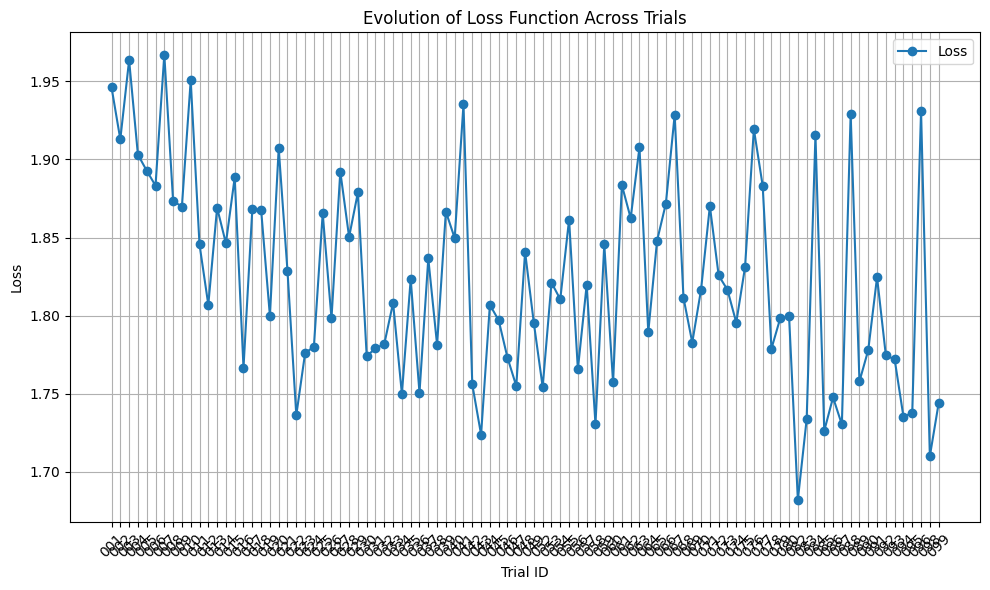

In [10]:
import matplotlib.pyplot as plt

# Extract trial information from the tuner
trials = auto_model.tuner.oracle.trials

# Collect loss values for all trials
trial_ids = []
loss_values = []

for trial_id, trial in trials.items():
    if (trial.status == "COMPLETED") and (trial.score<=2.0):  # Only consider completed trials
        trial_ids.append(trial_id)
        loss_values.append(trial.score)  # The score is the loss value

# Sort trials by their IDs (optional, for better visualization)
sorted_indices = sorted(range(len(trial_ids)), key=lambda i: trial_ids[i])
trial_ids = [trial_ids[i] for i in sorted_indices]
loss_values = [loss_values[i] for i in sorted_indices]

# Plot the evolution of the loss function
plt.figure(figsize=(10, 6))
plt.plot(trial_ids, loss_values, marker='o', label='Loss')
plt.title('Evolution of Loss Function Across Trials')
plt.xlabel('Trial ID')
plt.ylabel('Loss')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()